## Load module

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.metrics import mean_squared_error, r2_score
import math

## Set parameter

In [81]:
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, usecols=['Sales'])
n_train = int(len(df) * 0.8)
n_train

86

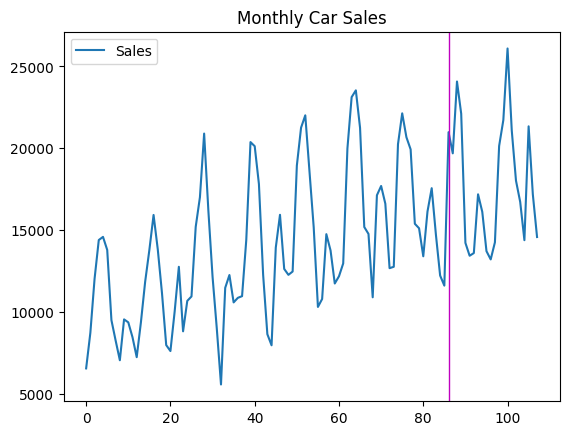

In [82]:
df.plot()
plt.axvline(n_train, c='m', lw=1.0)
plt.title('Monthly Car Sales')
plt.show()

## Prepare dataset

In [83]:
pitch = 5  # reset y every 20 value
step = 2    
N = 100    # number of steps
n_train = int(N*0.7)  # number of training steps

def gen_data(x):            # generate data by mod
    return (x%pitch)/pitch  # normalize to [0,1]

t = np.arange(1,N+1)
# t = np.flip(t)  # reverse time
# y = [gen_data(x) for x in t]  # generate data list
y = gen_data(t)  # generate data numpy array

In [84]:
from sklearn.preprocessing import MinMaxScaler



# Reproducibility
#torch.manual_seed(42)
#np.random.seed(42)

# Define nomalizer
# -------------------------------
# Scaling and sequence creation
# -------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(df[['Sales']].values.astype('float32'))

# test

values = y.reshape(-1, 1)  # reshape to 2D array for scaler
print(values.shape)

def create_sequences(series, step=1):
    X, y = [], []
    for i in range(len(series) - step):
        X.append(series[i:i+step])
        y.append(series[i+step])
    return np.array(X), np.array(y)

step = 3
X_all, y_all = create_sequences(values, step=step)
print("X_all shape:", X_all.shape, " y_all shape:", y_all.shape)
print("X_all:", X_all[:5])
print("y_all:", y_all[:5])

# -------------------------------
# Train/Validation/Test split
# -------------------------------
n_total = len(X_all)
n_train = int(n_total * 0.8)
X_train_full, y_train_full = X_all[:n_train], y_all[:n_train]
X_test, y_test = X_all[n_train:], y_all[n_train:]

n_val = max(1, int(len(X_train_full) * 0.1))
n_train_main = len(X_train_full) - n_val


class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


full_ds = SeqDataset(X_train_full, y_train_full)
train_ds = SeqDataset(X_train_full[:n_train_main], y_train_full[:n_train_main])
val_ds = SeqDataset(X_train_full[n_train_main:], y_train_full[n_train_main:])
test_ds = SeqDataset(X_test, y_test)

batch_size = 4
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

data_iter = iter(train_loader)
X_batch, y_batch = next(data_iter)
print("X_batch shape:", X_batch.shape, " y_batch shape:", y_batch.shape)
print("X_batch:")
print(X_batch)
print("y_batch:")
print(y_batch)


(100, 1)
X_all shape: (97, 3, 1)  y_all shape: (97, 1)
X_all: [[[0.2]
  [0.4]
  [0.6]]

 [[0.4]
  [0.6]
  [0.8]]

 [[0.6]
  [0.8]
  [0. ]]

 [[0.8]
  [0. ]
  [0.2]]

 [[0. ]
  [0.2]
  [0.4]]]
y_all: [[0.8]
 [0. ]
 [0.2]
 [0.4]
 [0.6]]
X_batch shape: torch.Size([4, 3, 1])  y_batch shape: torch.Size([4, 1])
X_batch:
tensor([[[0.0000],
         [0.2000],
         [0.4000]],

        [[0.8000],
         [0.0000],
         [0.2000]],

        [[0.6000],
         [0.8000],
         [0.0000]],

        [[0.4000],
         [0.6000],
         [0.8000]]])
y_batch:
tensor([[0.6000],
        [0.4000],
        [0.2000],
        [0.0000]])


## Create model

In [ ]:
"""
in Pytorch before using LSTM output, to linear layer,
if you want to use the output of the last time step,
you need to reshape the output to (batch_size, hidden_size). out[:, -1, :]
but if you want to use the output of all time steps,
you need to reshape the output to (batch_size, time_steps, hidden_size). out.reshape(batch_size, -1)


return_sequences=False (Default): When this is False, 
the LSTM layer automatically returns only the output of the last time step. 
The output shape will be (batch_size, units). Your TensorFlow code uses this default behavior.

return_sequences=True: If you were to set this to True, 
the LSTM layer would return the full sequence of hidden states for every time step, 
with a shape of (batch_size, time_steps, units).
"""

In [85]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super().__init__()
        """
        tensor of shape (L,Hin)  for unbatched input
        tensor of shape (B,L,Hin) for batched input (batch_first=True)
        tensor of shape (L,B,Hin) for batched input (batch_first=False)
        tensor of shape (L,Hout) for unbatched output
        tensor of shape (B,L,Hout) for batched output (batch_first=True)
        where   L is the sequence length (time steps),
                B is the number of sequences (the batch size), 
                Hin is the input size,
        """
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # print("Input shape:", self.lstm(x[0]))
        # print("Type: ", type(self.lstm(x[0])[0]))
        # print(self.lstm(x[0])[0][0])
        # print(x.shape)
        out, _ = self.lstm(x)
        out = torch.relu(out)
        last = out[:, -1, :]
        return self.fc(last)

In [86]:
model = LSTMRegressor(input_size=1, hidden_size=32, num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Train model

In [87]:
# -------------------------------
# Training with Early Stopping
# -------------------------------
def train_one_epoch(model, loader, optimizer, criterion, device="cpu"):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        print("Input shape:", xb.shape)
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, criterion, device="cpu"):
    model.eval()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        # print("Input shape:", xb.shape)
        # print("Type: ", type(xb))
        # print(xb)
        preds = model(xb)
        loss = criterion(preds, yb)
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

In [88]:

epochs = 100
best_val = float('inf')
patience = 10
patience_cnt = 0
history = {'train_loss': [], 'val_loss': []}

for epoch in range(1, epochs+1):
    tr = train_one_epoch(model, train_loader, optimizer, criterion)
    vl = evaluate(model, val_loader, criterion)
    history['train_loss'].append(tr)
    history['val_loss'].append(vl)
    print(f"Epoch {epoch:03d} | train {tr:.6f}| val {vl:.6f}")

    if vl < best_val - 1e-6:
        best_val = vl
        patience_cnt = 0
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    else:
        patience_cnt += 1
        if patience_cnt >= patience:
            print("Early stopping!")
            break

if 'best_state' in locals():
    model.load_state_dict(best_state)

Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([2, 3, 1])
Epoch 001 | train 0.297309| val 0.300949
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: torch.Size([4, 3, 1])
Input shape: t

## Ploting

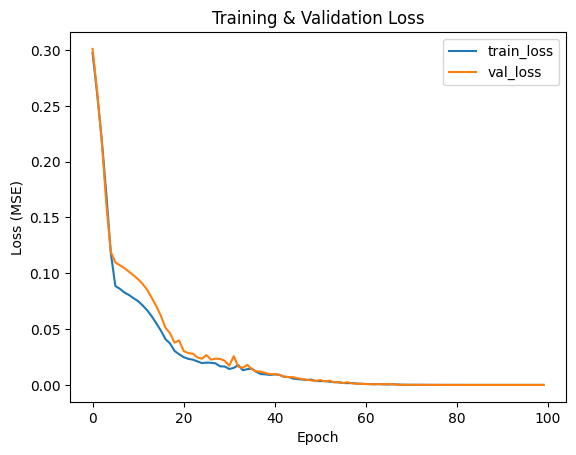

In [89]:
# -------------------------------
# Plot training curves
# -------------------------------
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

## Prediction

In [90]:
# -------------------------------
# Evaluation on Test Set
# -------------------------------
@torch.no_grad()
def predict_all(model, loader, device="cpu"):
    model.eval()
    preds, ys = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        print("Input shape for prediction:", xb.shape)
        print(xb)
        out = model(xb).cpu().numpy()
        preds.append(out)
        ys.append(yb.numpy())
    return np.vstack(preds), np.vstack(ys)

y_pred_test, y_true_test = predict_all(model, test_loader)
y_pred_inv = scaler.inverse_transform(y_pred_test)
y_true_inv = scaler.inverse_transform(y_true_test)

mse = mean_squared_error(y_true_inv, y_pred_inv)
rmse = math.sqrt(mse)
r2 = r2_score(y_true_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f} | RMSE: {rmse:.4f} | R^2: {r2:.4f}")


Input shape for prediction: torch.Size([4, 3, 1])
tensor([[[0.6000],
         [0.8000],
         [0.0000]],

        [[0.8000],
         [0.0000],
         [0.2000]],

        [[0.0000],
         [0.2000],
         [0.4000]],

        [[0.2000],
         [0.4000],
         [0.6000]]])
Input shape for prediction: torch.Size([4, 3, 1])
tensor([[[0.4000],
         [0.6000],
         [0.8000]],

        [[0.6000],
         [0.8000],
         [0.0000]],

        [[0.8000],
         [0.0000],
         [0.2000]],

        [[0.0000],
         [0.2000],
         [0.4000]]])
Input shape for prediction: torch.Size([4, 3, 1])
tensor([[[0.2000],
         [0.4000],
         [0.6000]],

        [[0.4000],
         [0.6000],
         [0.8000]],

        [[0.6000],
         [0.8000],
         [0.0000]],

        [[0.8000],
         [0.0000],
         [0.2000]]])
Input shape for prediction: torch.Size([4, 3, 1])
tensor([[[0.0000],
         [0.2000],
         [0.4000]],

        [[0.2000],
         [0.40

## Plot prediction

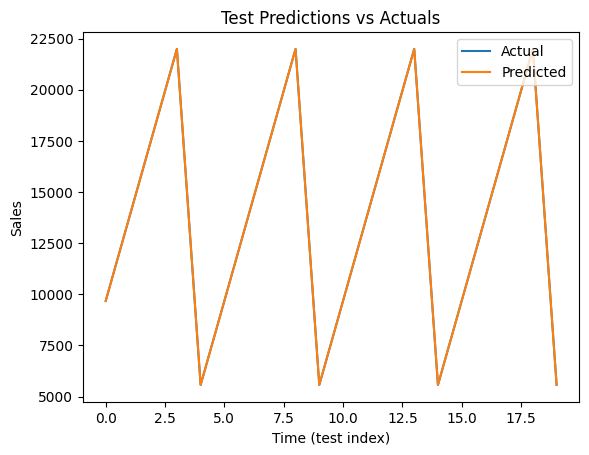

In [91]:
# -------------------------------
# Plot predictions
# -------------------------------
plt.plot(y_true_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.xlabel('Time (test index)')
plt.ylabel('Sales')
plt.legend()
plt.title('Test Predictions vs Actuals')
plt.show()

## Forcasting

In [92]:
# -------------------------------
# One-step ahead forecast
# -------------------------------
X_input = X_train_full[-1:,:,:]
X_input_t = torch.from_numpy(X_input).float()
print("Input shape for prediction:", X_input_t.shape)
with torch.no_grad():
    pred_scaled = model(X_input_t).cpu().numpy()
pred_value = scaler.inverse_transform(pred_scaled)[0,0]
print("One-step ahead prediction based on last training window:", pred_value)


Input shape for prediction: torch.Size([1, 3, 1])
One-step ahead prediction based on last training window: 5571.003
